# Betting markets - chart election winner at sportsbet

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python set-up</a></span></li><li><span><a href="#Get-data" data-toc-modified-id="Get-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get data</a></span></li><li><span><a href="#Convert-odds-to-probabilities" data-toc-modified-id="Convert-odds-to-probabilities-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Convert odds to probabilities</a></span></li><li><span><a href="#Plot-probabilities" data-toc-modified-id="Plot-probabilities-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plot probabilities</a></span></li></ul></div>

## Python set-up

In [1]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.dates as mdates
import matplotlib.units as munits
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator

import common

# matplotlib stuff for date formatting xticklabels
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter
munits.registry[pd.Timestamp] = converter
munits.registry[pd.Period] = converter
plt.style.use('./markgraph.mplstyle')

/Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Get data

In [2]:
FILE = '../historical-data/sportsbet-2022-type-of-parliament.csv'
df = pd.read_csv(FILE, na_values = '-', parse_dates=['datetime'])
df = df.pivot(index='datetime', columns='variable', values='value').sort_index(ascending=True)
del df['Any Other']

In [3]:
df.index.dtype

dtype('<M8[ns]')

In [4]:
# Fix up column names
names = {
    'Liberal/National Coalition Majority': 'Coalition Majority',
    'Liberal/National Coalition Minority': 'Coalition Minority',
}
order = ['Labor Majority', 'Labor Minority', 'Coalition Minority', 'Coalition Majority',]
df = df.rename(columns=names)[order]
df.tail()

variable,Labor Majority,Labor Minority,Coalition Minority,Coalition Majority
datetime,,,,
2022-01-21 11:45:41.528839,1.7,4.5,5.75,4.25
2022-01-22 11:46:16.081133,1.7,4.5,5.75,4.25
2022-01-23 11:45:44.988378,1.7,4.5,5.75,4.25
2022-01-24 11:45:45.473452,1.7,4.5,5.75,4.25
2022-01-25 11:45:43.905110,1.7,4.5,5.75,4.25


## Convert odds to probabilities

In [5]:
odds = 1 / df
total = odds.sum(axis=1)
probs = odds.div(total, axis=0)

probs.tail()

variable,Labor Majority,Labor Minority,Coalition Minority,Coalition Majority
datetime,,,,
2022-01-21 11:45:41.528839,0.482293,0.182199,0.142591,0.192917
2022-01-22 11:46:16.081133,0.482293,0.182199,0.142591,0.192917
2022-01-23 11:45:44.988378,0.482293,0.182199,0.142591,0.192917
2022-01-24 11:45:45.473452,0.482293,0.182199,0.142591,0.192917
2022-01-25 11:45:43.905110,0.482293,0.182199,0.142591,0.192917


## Plot probabilities

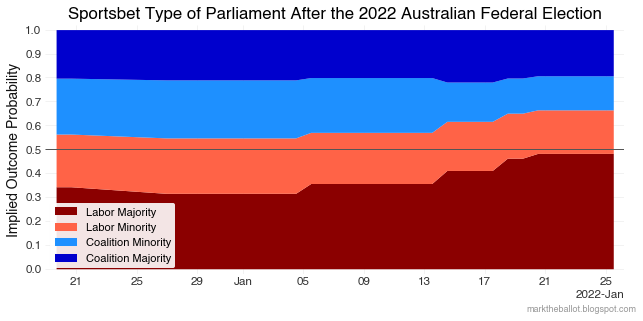

In [6]:
fig, ax = common.initiate_plot()

colors = ['darkred', 'tomato', 'dodgerblue', 'mediumblue']

from_ = np.repeat(0, len(probs))
for i, column in enumerate(probs.columns):
    to_ = from_ + probs[column]
    ax.fill_between(probs.index, from_, to_, label=column, color=colors[i])
    from_ = to_
ax.legend(loc='lower left', framealpha=0.9, prop={'size':11})
ax.axhline(0.5, lw=1, c='#555555')
ax.yaxis.set_major_locator(MaxNLocator(11)) 
title = f'Sportsbet Type of Parliament After the 2022 Australian Federal Election'
common.plot_finalise(ax, title=title, ylabel='Implied Outcome Probability')

In [7]:
win_prob = pd.DataFrame([probs['Labor Majority'] + probs['Labor Minority'], 
                         probs['Coalition Minority'] + probs['Coalition Majority']],
                        index=['Labor', 'Coalition']).T



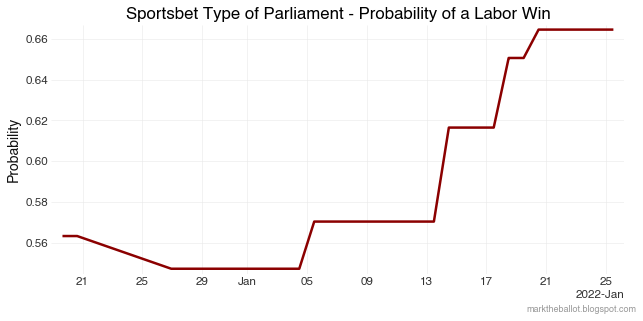

In [9]:
fig, ax = common.initiate_plot()
ax.plot(win_prob.index, win_prob['Labor'], lw=2.5, color='darkred')
title = 'Sportsbet Type of Parliament - Probability of a Labor Win'
common.plot_finalise(ax, title=title, ylabel='Probability')